In [1]:
import pickle
import numpy as np
import pdb

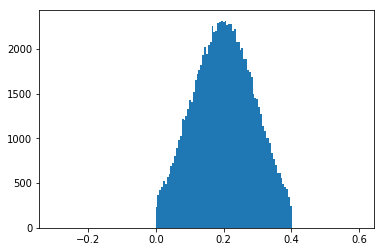

In [22]:
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
f, ax = plt.subplots()
rv = truncnorm.rvs(-2, 2, loc=0, scale=0.1, size=100000) + 0.2
plt.hist(rv, bins='auto', range=(-0.3,0.6))
plt.show()

In [24]:
from scipy.stats import bernoulli
r = bernoulli.rvs(0.5, size=10)
print(r)

[0 0 1 1 0 0 1 1 0 0]


In [2]:
with open('top10_off_players.pickle','rb') as f:
    top10_off_players = pickle.load(f)
    top10_off_players = [item[0] for item in top10_off_players]
    print(top10_off_players)
with open('all_def_players_in_selected_poss_for_top10.pickle','rb') as f:
    all_def_players = pickle.load(f)
    print(all_def_players[:10])
with open('poss_data_for_top10.pickle','rb') as f:
    all_poss = pickle.load(f)
    print(all_poss[0][0])

['522878', '457594', '469218', '329525', '3234', '463121', '172890', '457611', '3100', '395388']
['712593', '411111', '172692', '739968', '551760', '168029', '794503', '550431', '833017', '503689']
['2015102810', 7, 1, 488.25, 17.28, '395388', 27.90421, 14.53051, '712593', 6.37316516284, '', '']


In [3]:
max_seq_length = 0
for poss in all_poss:
    max_seq_length = max(max_seq_length, len(poss))

In [4]:
print(max_seq_length)

50


In [5]:
def generate_player_index_lookup_dict(player_list, player_type):
    index2player = {}
    for i in range(1, len(player_list)+1):
        index2player[i] = player_list[i-1]
        
    player2index = {}
    for index, player in index2player.items():
        player2index[player] = index
    
    if player_type == 'def':
        index += 1
        index2player[index] = ''
        player2index[''] = index
        
    return player2index, index2player 

In [6]:
offplayer2index, index2offplayer = generate_player_index_lookup_dict(top10_off_players, 'off')
print('', offplayer2index,'\n',index2offplayer)

 {'522878': 1, '457594': 2, '469218': 3, '329525': 4, '3234': 5, '463121': 6, '172890': 7, '457611': 8, '3100': 9, '395388': 10} 
 {1: '522878', 2: '457594', 3: '469218', 4: '329525', 5: '3234', 6: '463121', 7: '172890', 8: '457611', 9: '3100', 10: '395388'}


In [7]:
defplayer2index, index2defplayer = generate_player_index_lookup_dict(all_def_players, 'def')
print('',defplayer2index, '\n', index2defplayer)

 {'712593': 1, '411111': 2, '172692': 3, '739968': 4, '551760': 5, '168029': 6, '794503': 7, '550431': 8, '833017': 9, '503689': 10, '837030': 11, '395391': 12, '512053': 13, '467468': 14, '174092': 15, '603100': 16, '502871': 17, '469085': 18, '3493': 19, '639311': 20, '398090': 21, '401085': 22, '329715': 23, '172997': 24, '329873': 25, '457576': 26, '603096': 27, '512591': 28, '3155': 29, '3508': 30, '57934': 31, '295922': 32, '292397': 33, '262890': 34, '599780': 35, '550049': 36, '599797': 37, '469218': 38, '277552': 39, '552805': 40, '172922': 41, '168051': 42, '266367': 43, '398142': 44, '511057': 45, '399725': 46, '410764': 47, '237675': 48, '280587': 49, '393436': 50, '552381': 51, '457605': 52, '697132': 53, '514882': 54, '398068': 55, '457611': 56, '173004': 57, '330421': 58, '329672': 59, '229738': 60, '609569': 61, '253980': 62, '748788': 63, '552523': 64, '553166': 65, '553575': 66, '229602': 67, '509449': 68, '509450': 69, '266358': 70, '398066': 71, '699950': 72, '26289

In [8]:
def off_player_input_array(poss_data, player2index, max_seq_length):
    off_player_input = np.zeros([len(poss_data), max_seq_length], dtype=np.int32)
    for i,poss in enumerate(poss_data):
        ball_handler = poss[0][5]
        index = player2index[ball_handler]
        len_one_poss = len(poss) - 1
        off_player_input[i,:len_one_poss] = index
        
    return off_player_input

In [9]:
off_player_input = off_player_input_array(all_poss, offplayer2index, max_seq_length-1)
print(off_player_input.shape)

(3448, 49)


In [10]:
def def_player_input_array(poss_data, player2index, max_seq_length):
    def_player_input = np.zeros([len(poss_data), max_seq_length], dtype=np.int32)
    for i,poss in enumerate(poss_data):
        for j,moment in enumerate(poss[:-1]):
            def_player = moment[8]
            index = player2index[def_player]
            def_player_input[i,j] = index
        
    return def_player_input

In [11]:
def_player_input = def_player_input_array(all_poss, defplayer2index, max_seq_length-1)
print(def_player_input.shape)

(3448, 49)


In [12]:
def normalization_location(x, y, x_bounds=(0.0, 47.0, 94.0), y_bounds=(0.0, 50.0)):
    
    x = max(x, x_bounds[0])
        
    y = max(y, y_bounds[0])
    y = min(y, y_bounds[1])
    
    if x > x_bounds[1]:
        x = min(x, x_bounds[2])
        x = x_bounds[2] - x
        y = y_bounds[1] - y
    
    return x/x_bounds[1], y/y_bounds[1]

In [13]:
def normalization_shotclock(shot_clock, threshold=24.0):
    return shot_clock/threshold

In [14]:
def normalization_distance(distance, threshold=10.0):
    if distance == '' or distance == None:
        print('open occurs')
        return 1.0
    else:
        distance = distance
        distance = min(distance, threshold)
        return distance/threshold

In [15]:
def auxiliary_input_array(poss_data, max_seq_length, aux_data_len=4):
    auxiliary_input = np.zeros([len(poss_data), max_seq_length, aux_data_len], dtype=np.float32)
    for i,poss in enumerate(poss_data):
        for j,moment in enumerate(poss[:-1]):
            normalized_shotclock = normalization_shotclock(moment[4])
            normalized_x, normalized_y = normalization_location(moment[6], moment[7])
            normalized_distance = normalization_distance(moment[9])
            auxiliary_input[i,j,:] = np.array([normalized_shotclock, normalized_x, normalized_y, normalized_distance])
    return auxiliary_input

In [16]:
auxiliary_input = auxiliary_input_array(all_poss, max_seq_length-1)
print(auxiliary_input.shape)

(3448, 49, 4)


In [17]:
print(np.min(auxiliary_input[:,:,3]), np.max(auxiliary_input[:,:,3]))

0.0 1.0


In [18]:
def generate_Y_dataset(poss_data, max_seq_length):
    Y = np.zeros([len(poss_data), max_seq_length, 2], dtype=np.float32)
    for i,poss in enumerate(poss_data):
        for j,moment in enumerate(poss[1:]):
            normalized_x, normalized_y = normalization_location(moment[6], moment[7])
            Y[i,j,:] = np.array([normalized_x, normalized_y])
    
    return Y

In [19]:
Y = generate_Y_dataset(all_poss, max_seq_length-1)
print(Y.shape)

(3448, 49, 2)


In [20]:
print(np.min(Y[:,:,1]), np.max(Y[:,:,1]))

0.0 1.0


In [21]:
from keras.models import Model
from keras.layers import Input, Embedding, concatenate, Dense, Masking
from keras.layers.recurrent import LSTM

Using TensorFlow backend.


In [47]:
offplayer_input = Input(shape=(max_seq_length-1,), dtype=np.int32, name='offplayer_input')

In [48]:
defplayer_input = Input(shape=(max_seq_length-1,), dtype=np.int32, name='defplayer_input')

In [49]:
aux_input = Input(shape=(max_seq_length-1,4), dtype=np.float32, name='aux_input')

In [50]:
off_x = Embedding(output_dim=25, input_dim=len(top10_off_players)+1, input_length=max_seq_length-1, mask_zero=True)(offplayer_input)

In [51]:
def_x = Embedding(output_dim=25, input_dim=len(all_def_players)+1, input_length=max_seq_length-1, mask_zero=True)(defplayer_input)

In [52]:
x = concatenate([off_x, def_x, aux_input])

In [53]:
x = Masking(mask_value=0.)(x)

In [54]:
x = LSTM(25, return_sequences=True)(x)

In [55]:
x = LSTM(25, return_sequences=True)(x)

In [56]:
output = Dense(2, activation='linear')(x)

In [57]:
model = Model(inputs=[offplayer_input, defplayer_input, aux_input], outputs=[output])

In [58]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
offplayer_input (InputLayer)     (None, 49)            0                                            
____________________________________________________________________________________________________
defplayer_input (InputLayer)     (None, 49)            0                                            
____________________________________________________________________________________________________
embedding_3 (Embedding)          (None, 49, 25)        275         offplayer_input[0][0]            
____________________________________________________________________________________________________
embedding_4 (Embedding)          (None, 49, 25)        9675        defplayer_input[0][0]            
___________________________________________________________________________________________

In [59]:
model.compile(loss="mse", optimizer="rmsprop")

In [35]:
indices_disqualified_poss = []
for i in range(off_player_input.shape[0]):
    if np.sum((off_player_input[i,:]>0).astype(np.int)) < 5:
        indices_disqualified_poss.append(i)
print(indices_disqualified_poss)

[1, 25, 94, 209, 293, 329, 370, 412, 512, 559, 587, 723, 859, 907, 914, 1021, 1197, 1275, 1289, 1305, 1394, 1429, 1540, 1549, 1701, 1726, 1734, 2028, 2055, 2103, 2183, 2192, 2235, 2316, 2351, 2355, 2419, 2508, 2516, 2563, 2604, 2639, 2719, 2761, 2811, 2979, 3086, 3108, 3122, 3417]


In [36]:
indices_qualified_poss = [i for i in range(off_player_input.shape[0]) if i not in indices_disqualified_poss]

In [37]:
off_player_input = off_player_input[indices_qualified_poss]

In [38]:
def_player_input = def_player_input[indices_qualified_poss]

In [39]:
auxiliary_input = auxiliary_input[indices_qualified_poss]

In [40]:
Y = Y[indices_qualified_poss]

In [41]:
print(off_player_input.shape, def_player_input.shape, auxiliary_input.shape, Y.shape)

(3398, 49) (3398, 49) (3398, 49, 4) (3398, 49, 2)


In [42]:
# fix random seed for reproducibility
import random
random.seed(7)
indices_for_test = random.sample(range(off_player_input.shape[0]), 398)
Test_X_off, Test_X_def, Test_X_aux = off_player_input[indices_for_test], def_player_input[indices_for_test], auxiliary_input[indices_for_test] 
Test_Y = Y[indices_for_test]

In [43]:
indices_for_train_validation = [i for i in range(off_player_input.shape[0]) if i not in indices_for_test]

In [44]:
Train_X_off, Train_X_def, Train_X_aux = off_player_input[indices_for_train_validation], def_player_input[indices_for_train_validation], auxiliary_input[indices_for_train_validation]
Train_Y = Y[indices_for_train_validation]

In [45]:
Train_Y.shape

(3000, 49, 2)

In [61]:
model.fit([Train_X_off, Train_X_def, Train_X_aux], Train_Y, batch_size=32, epochs=10, validation_split=0.1)

Train on 2700 samples, validate on 300 samples
Epoch 1/10
2700/2700 [==============================] - 24s - loss: 4.9592e-04 - val_loss: 4.8344e-04
Epoch 2/10
2700/2700 [==============================] - 26s - loss: 4.2494e-04 - val_loss: 4.6680e-04
Epoch 3/10
  64/2700 [..............................] - ETA: 27s - loss: 4.3833e-04

KeyboardInterrupt: 

In [62]:
model.evaluate([Test_X_off, Test_X_def, Test_X_aux], Test_Y)

398/398 [==============================] - 0s     


0.00042212446192139058